<a href="https://colab.research.google.com/github/hyojgun/hyojeong/blob/main/Auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor


def gaussian_noise(x, scale=0.8):
  gaussian_data_x = x+ np.random.normal(
      loc =0,
      scale= scale,
      size = x.shape
  )

  gaussian_data_x = np.clip(
      gaussian_data_x,0,1
  )

  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
  return gaussian_data_x



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.81MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]
<ipython-input-2-9a0d33a276c2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



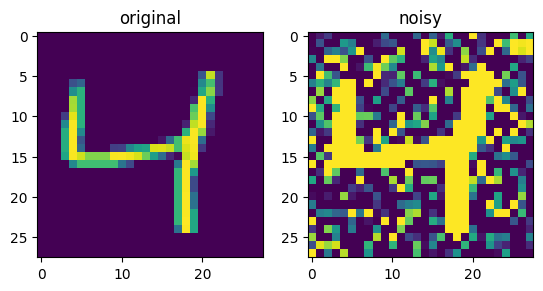

In [3]:
training_data = MNIST(
    root ="./",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = MNIST(
    root ="./",
    train = False,
    download = True,
    transform = ToTensor()
)

img = training_data.data[2]

gaussian = gaussian_noise(img)

plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('noisy')
plt.imshow(gaussian)

plt.show()

In [4]:
from torch.utils.data.dataset import Dataset


class Denoising(Dataset):
  def __init__(self):
    self.mnist = MNIST(
        root ="./",
        train = True,
        download = True,
        transform = ToTensor()
    )
    self.data = []

    for i in range(len(self.mnist)):
      noisy_input = gaussian_noise(self.mnist.data[i])
      input_tensor = torch.tensor(noisy_input)
      self.data.append(torch.unsqueeze(input_tensor,dim= 0))


  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
   data = self.data[i]

   label = self.mnist.data[i]/255

   return data, label



In [9]:
import torch.nn as nn

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(
        in_channels,
        hidden_dim,
        kernel_size = 3,
        padding = 1
    )

    self.conv2 = nn.Conv2d(
        hidden_dim,
        out_channels,
        kernel_size = 3,
        padding = 1
    )

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)

    return x






class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim =16)
    self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim =8)

    self.pool = nn.AvgPool2d(kernel_size=2,stride =2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)

    return x


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim =8)
    self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim =16)

    self.conv3 = nn.Conv2d(in_channels = 16,out_channels=1, kernel_size =3, padding=1)

    self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)

  def forward(self,x):
    x = self.conv1(x)
    x = self.upsample1(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    x = self.conv3(x)

    return x

class CAE(nn.Module):
  def __init__(self):
    super(CAE, self).__init__()
    self.enc = Encoder()
    self.dec = Decoder()

  def forward(self, x):
    x = self.enc(x)
    x = self.dec(x)
    x = torch.squeeze(x)

    return x



In [10]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam


device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

trainset = Denoising()
train_loader = DataLoader(
    trainset,
    batch_size = 32)

model = CAE().to(device)


lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(20):
  iterator = tqdm.tqdm(train_loader)

  for data, label in iterator:
    optim.zero_grad()
    pred = model(data.to(device))

    loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./CAE.pth")


<ipython-input-2-9a0d33a276c2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-4-847275e1694e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch:20 loss:0.007420709822326899: 100%|██████████| 1875/1875 [00:11<00:00, 160.30it/s]


<ipython-input-13-e3f9b60f6882>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./CAE.pth", map_location = device))
<ipython-input-2-9a0d3

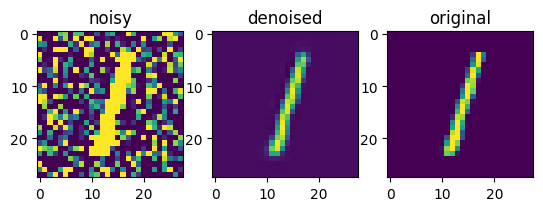

In [13]:
model.cpu()

with torch.no_grad():
  model.load_state_dict(torch.load("./CAE.pth", map_location = device))

  img = test_data.data[2]
  gaussian = gaussian_noise(img)


  input = torch.unsqueeze(gaussian, dim=0)
  input.type(torch.FloatTensor)
  input.to(device)
  input= torch.unsqueeze(input, dim=0)

  plt.subplot(1,3,1)
  plt.imshow(torch.squeeze(gaussian))
  plt.title('noisy')

  plt.subplot(1,3,2)
  plt.imshow(torch.squeeze(model(input)))
  plt.title('denoised')

  plt.subplot(1,3,3)
  plt.imshow(torch.squeeze(img))
  plt.title('original')

  plt.show()

